In [2]:
#All neccesary classes for project

#general
import seaborn as sns
import scipy.stats as ss
import pandas as pd
import numpy as np
import os
import pickle
import time
import sys

#for preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tensorflow as tf

#for machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

#for evaluation
from sklearn.metrics import confusion_matrix

from sklearn.metrics import f1_score

#for utility packages
from Utilities.utilities import import_data
from Utilities.utilities import DataFrameSelector
from Utilities.utilities import CategoricalEncoder
from Utilities.utilities import display_scores
from Utilities.utilities import pipeline_transform
from Utilities.utilities import reset_graph
from Utilities.models import DNN_Model
from Utilities.models import cross_val_score_dnn
from functools import partial

#image manipulation
from PIL import Image as PI
from resizeimage import resizeimage
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.utils.data_utils import get_file
import imagenet_helper_files.vgg_preprocessing
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim.nets import resnet_v2
import imagenet_helper_files.pnasnet as nas
import imagenet_helper_files.nets.inception as inception
import imagenet_helper_files.nets.resnet_v2 as resnet

#Import Custom Functions
from Utilities.model_builder import get_image
from Utilities.model_builder import get_file_lists
from Utilities.model_builder import parse_record
from Utilities.model_builder import get_batch
from Utilities.model_builder import build_iterator
from Utilities.bounded_model_builder import build_bounded_iterator
from Utilities.model_builder import get_values_imagenet
from Utilities.model_builder import get_values_bounded
from Utilities.models import log_dir_build
from Utilities.utilities import generate_image
from Utilities.utilities import generate_image_array
from Utilities.cell_net_predictor import Binary_Categorical_Predictor
from Utilities.build_image_data_notebook import process_dataset


Using TensorFlow backend.


# Load the Data

Here we will load the training and validation data in order to do training

In [3]:
#Build tf_records
#Set Variables
validation_directory = "D:/Machine_Learning/Datasets/corpus_learning/validation"
train_directory = "D:/Machine_Learning/Datasets/corpus_learning/train"
output_directory = "D:/Machine_Learning/Datasets/corpus_learning/tf_records_2"

In [4]:
#Import TFRecords for both Training and Testing of the Dat
#Use the build_image_data.py to create these sets from your data

train_list, val_list = get_file_lists(output_directory)
train_list

['D:/Machine_Learning/Datasets/corpus_learning/tf_records_2\\train-00000-of-00002',
 'D:/Machine_Learning/Datasets/corpus_learning/tf_records_2\\train-00001-of-00002']

In [4]:
#Test pulling a piece of data out of the set to ensure that records were created properly
with tf.Session() as sess:
    iterator_train = build_bounded_iterator(True, train_list, 1, num_epochs=1, num_parallel_calls=8, num_points = 8)
    iterator_test = build_bounded_iterator(False, val_list, 1, num_epochs=1, num_parallel_calls=4, num_points = 8)
    next_train = iterator_train.get_next()
    next_test = iterator_test.get_next()
    X_val, Y_val, file = next_train
    X_val, Y_val, name = get_values_bounded(sess, X_val, Y_val, file, 37.5)
  

In [5]:
Y_val 

array([[ 183.30429077,  172.77897644,  196.95774841,  139.25695801,
         185.08752441,  181.69137573,  148.24996948,  194.36610413]], dtype=float32)

In [6]:
#display an example and label

x_val = X_val.reshape(331,331,3)
y_val = Y_val[0]
x_array = y_val[0:8:2] 
y_array = y_val[1:8:2]



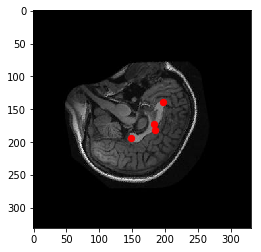

array([ 183.30429077,  172.77897644,  196.95774841,  139.25695801,
        185.08752441,  181.69137573,  148.24996948,  194.36610413], dtype=float32)

In [7]:
from matplotlib import pyplot as plt
plt.imshow(x_val, interpolation='nearest')
plt.scatter(x=x_array, y=y_array, c='r', s=40)
plt.axis('on')
plt.show()
y_val

In [6]:
name

# Build the Neural Network on top of Large Nas-Net


Here we will build the Nas-Net and then stack our own network on top

In [4]:

#import pnas_net model

#Nasnet Model Location
res_net_model = 'D:/AI/models/res_net/resnet_v2_152.ckpt'
landmark_ml_logs = 'D:/AI/models/landmark_ml/logs'
landmark_ml_model = 'D:/AI/models/landmark_ml/model/landmark_ml_v3'
landmark_ml_model_best = 'D:/AI/models/landmark_ml/model/landmark_ml_best_v3'


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [1]:
reset_graph()

#Set constants for Neural Network
dropout_rate = .01
learning_rate = 0.1
#n_hidden1 = 2000
n_hidden2 = 1000
n_hidden3 = 500
n_hidden4 = 100
n_hidden5 = 50
n_final_layer = 8


#Placeholder for input data
X = tf.placeholder(tf.float32, shape=[None, 331, 331, 3], name="input")
y = tf.placeholder(tf.float32, shape=[None,8], name="bounding_box")
training = tf.placeholder_with_default(False, shape=(), name = 'training')

#Define initalizer and batch normalization layers
bn_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9)
he_init = tf.contrib.layers.variance_scaling_initializer()


#Import the Nas_Net and build it
with slim.arg_scope(resnet.resnet_arg_scope()):
    net, end_points = resnet.resnet_v2_152(X, num_classes=1001, is_training=False)

    #A saver to load the pretrained Data
    saver = tf.train.Saver(name="Original_Saver")

    #For getting predictions from Original Network
    res_net_predictions = tf.get_default_graph().get_tensor_by_name("resnet_v2_152/predictions/Softmax:0")


    #Load in the noder where we are going to connect our own network
    last_feature_node = tf.get_default_graph().get_tensor_by_name("resnet_v2_152/pool5:0")
    

with tf.name_scope("Landmark_ML"):
    #Use a stop layer to freeze all the layers beneath in Nas-Net
    with tf.name_scope("Isolate_Image_Features"):
        #get the output of the last cell layer  
        starting_relu = tf.nn.relu(last_feature_node, name="first_relu")
        index = np.array([1,2])
        reduction_tensor = tf.constant(index)
        features = tf.reduce_mean(starting_relu, index, name="condensing_mean")
        #stop_layer = tf.stop_gradient(last_feature_node)
        #starting_relu = tf.nn.relu(stop_layer, name="first_relu")
        #starting_relu = tf.nn.relu(last_feature_node, name="first_relu")
        #mean_pool = tf.reduce_mean(starting_relu, indices, name="condensing_mean")
            
    """
    with tf.name_scope("Hidden_Layer_1"):
        hidden1 = tf.layers.dense(features, n_hidden1, name="hidden1", kernel_initializer=he_init)
        #hidden1 = tf.layers.dense(last_feature_node, n_hidden1, name="hidden1", kernel_initializer=he_init)
        hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
        bn1 = bn_batch_norm_layer(hidden1_drop)
        bn1_act = tf.nn.relu(bn1)
    
    """
    with tf.name_scope("Hidden_Layer_2"):
        hidden2 = tf.layers.dense(features, n_hidden2, name="hidden2", kernel_initializer=he_init)
        hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
        bn2 = bn_batch_norm_layer(hidden2_drop)
        bn2_act = tf.nn.relu(bn2)

    
    with tf.name_scope("Hidden_Layer_3"):
        hidden3 = tf.layers.dense(bn2_act, n_hidden3, name="hidden3", kernel_initializer=he_init)
        hidden3_drop = tf.layers.dropout(hidden3, dropout_rate, training=training)
        bn3 = bn_batch_norm_layer(hidden3_drop)
        bn3_act = tf.nn.relu(bn3) 
         
    with tf.name_scope("Hidden_Layer_4"):
        hidden4 = tf.layers.dense(bn3_act, n_hidden4, name="hidden4", kernel_initializer=he_init)
        hidden4_drop = tf.layers.dropout(hidden4, dropout_rate, training=training)
        bn4 = bn_batch_norm_layer(hidden4_drop)
        bn4_act = tf.nn.relu(bn4) 

    with tf.name_scope("Hidden_Layer_5"):
        hidden5 = tf.layers.dense(bn4_act, n_hidden5, name="hidden5", kernel_initializer=he_init)
        hidden5_drop = tf.layers.dropout(hidden5, dropout_rate, training=training)
        bn5 = bn_batch_norm_layer(hidden5_drop)
        bn5_act = tf.nn.relu(bn5) 
 
 
    with tf.name_scope("Final_Layer"):
        box_estimates = tf.layers.dense(bn5_act, n_final_layer, name="outputs")

    
    with tf.name_scope("loss"):
            loss = tf.norm(box_estimates-y, ord='euclidean')
            loss_summary_test = tf.summary.scalar('loss_summary_test', loss)
            loss_summary_train = tf.summary.scalar('loss_summary_train', loss)
            
    with tf.name_scope("train"):
        global_step = tf.Variable(0, trainable=False, name='global_step')
        
        #For momentum optomizer
        
        #decay_steps = 800
        #decay_rate = 1/8
        #learning_decay = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate)
        #optimizer = tf.train.MomentumOptimizer(learning_rate=learning_decay, momentum=0.9, use_nesterov=True)
        
        #For BN
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

          with tf.control_dependencies(update_ops):
                training_op = optimizer.minimize(loss, global_step=global_step)        
        
            
#Variables for global initialization
saver2 = tf.train.Saver(name="Full_Saver")
init = tf.global_variables_initializer()


NameError: name 'reset_graph' is not defined

In [7]:
#Initialize all variables and restore the lower layer
with tf.Session() as sess:
    #Initalizer all variables
    init.run()
    
    #Restore the pretrained variables from Nas-Net
    saver.restore(sess, res_net_model)
    
    
    #Save all of these variables to the new Cell_Net Model
    saver2.save(sess, landmark_ml_model)
    saver2.save(sess, landmark_ml_model_best)

INFO:tensorflow:Restoring parameters from D:/AI/models/res_net/resnet_v2_152.ckpt


In [ ]:
#For Exporting Graph
filewriter = tf.summary.FileWriter(landmark_ml_logs, tf.get_default_graph())

# Train the Network

Here we are going to train the network. Accuracy/Loss is recorded
Note for this version, a certain amount of the data is seen every training step. 
set train_size for how many images are trained on in each epoch
set batch_size for how many images are trained at once.
num_epochs is how many times the network sees that ammount of training data


In [8]:
# Save the Graph into a file with Filewriter and add summaries for this session
#This will be used for all the following
model_path = log_dir_build(landmark_ml_logs, "landmark_ml_v3")
filewriter = tf.summary.FileWriter(model_path, tf.get_default_graph())

In [9]:
#For doing the initial training
#Total number of epochs to train
num_epochs = 200
steps_between_test_save = 1
batch_size = 15
train_size = 1700
all_data_steps = np.int(np.floor(train_size/batch_size))
lowest_loss = 100
offset_correction = 37.5

#GPU Options
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.allow_growth = True


with tf.Session(config=config) as sess:
    start_time = time.time()
    #restore saver, build iterator, set the step to the global step
    saver2.restore(sess, landmark_ml_model)
    
    #Set up the global steps
    step = 0
    print("Loaded model. Training network initially. Logs into: " + model_path)
    
    iterator_train = build_bounded_iterator(True, train_list, batch_size, num_epochs=num_epochs, num_parallel_calls=8, num_points = 8)
    iterator_test = build_bounded_iterator(False, val_list, batch_size, num_epochs=num_epochs, num_parallel_calls=4, num_points = 8)
    next_train = iterator_train.get_next()
    next_test = iterator_test.get_next()
    
    #Get initial loss
    X_val, y_val, file = next_train
    X_val, y_val, filename = get_values_bounded(sess, X_val, y_val, file, offset_correction)
    loss_sum, loss_val = sess.run([loss_summary_train, loss], feed_dict = {X: X_val, y: y_val, training: False})
    filewriter.add_summary(loss_sum, step)
    print("Epoch: " + str(step) + " Loss: " + str(loss_val))
    
    #Iterate through training 
    while step < num_epochs:
        for i in range(all_data_steps):
            #Get training data
            X_val, y_val, file = next_train
            X_val, y_val, filename = get_values_bounded(sess, X_val, y_val, file, offset_correction)
        
            #run Training Op
            sess.run([training_op, extra_update_ops], feed_dict={X: X_val, y: y_val, training: True})
        
        #see if we are improving on the test data
        #Maybe Test Accuracy
        if ((step % steps_between_test_save) == 0 and step != 0) :
            X_val, y_val, file = next_test
            X_val, y_val, filename = get_values_bounded(sess, X_val, y_val, file, offset_correction)
            loss_sum, loss_val = sess.run([loss_summary_test, loss], feed_dict = {X: X_val, y: y_val, training: False})
            filewriter.add_summary(loss_sum, step)
            print("Epoch: " + str(step) + " Test Loss: " + str(loss_val))
            
            X_val, y_val, file = next_train
            X_val, y_val, filename = get_values_bounded(sess, X_val, y_val, file, offset_correction)
            loss_sum, loss_val = sess.run([loss_summary_train, loss], feed_dict = {X: X_val, y: y_val, training: False})
            filewriter.add_summary(loss_sum, step)
            print("Epoch: " + str(step) + " Train Loss: " + str(loss_val))
            saver2.save(sess, landmark_ml_model)
            if lowest_loss > loss_val:
                lowest_loss = loss_val
                saver2.save(sess, landmark_ml_model_best)
        step = step + 1
            
    #Finish the final Model
    saver2.save(sess, landmark_ml_model)
    end_time = time.time()
    total_steps = tf.train.global_step(sess, global_step)
    final_time = end_time - start_time
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " seconds.")
    print("Done!")

INFO:tensorflow:Restoring parameters from D:/AI/models/landmark_ml/model/landmark_ml_v3
Loaded model. Training network initially. Logs into: D:/AI/models/landmark_ml/logs/landmark_ml_v3-run-20181120023005/
Epoch: 0 Loss: 1798.0
Epoch: 1Test Loss: 284.69
Epoch: 1Train Loss: 257.906
Epoch: 2Test Loss: 270.198
Epoch: 2Train Loss: 240.316
Epoch: 3Test Loss: 297.346
Epoch: 3Train Loss: 253.217
Epoch: 4Test Loss: 304.072
Epoch: 4Train Loss: 249.312
Epoch: 5Test Loss: 281.55
Epoch: 5Train Loss: 240.465
Epoch: 6Test Loss: 301.742
Epoch: 6Train Loss: 266.465
Epoch: 7Test Loss: 276.686
Epoch: 7Train Loss: 252.077
Epoch: 8Test Loss: 277.985
Epoch: 8Train Loss: 259.457
Epoch: 9Test Loss: 296.593
Epoch: 9Train Loss: 272.284
Epoch: 10Test Loss: 281.851
Epoch: 10Train Loss: 255.478
Epoch: 11Test Loss: 299.5
Epoch: 11Train Loss: 265.367
Epoch: 12Test Loss: 268.502
Epoch: 12Train Loss: 256.308
Epoch: 13Test Loss: 297.261
Epoch: 13Train Loss: 257.482
Epoch: 14Test Loss: 307.703
Epoch: 14Train Loss: 247.

KeyboardInterrupt: 

# Do metric testing

Here we will run through all of the training data and relate accuracy with confidence

In [ ]:
out_of_set_net_model = 'D:/AI/models/out_of_set_net/model/out_of_set_net_best'
batch_size = 1
num_epochs = 1500

#Set up frame
column_list = ['Item_Number','Category','Category_Index','Category_Strength', 'Max_Confidence_Index_Value','Calculated_Confidence',
                                       'Correct_Confidence','Confidence_Score']
full_data_frame = pd.DataFrame(columns=column_list)



with tf.Session() as sess:
    
    #build the iterator with all the training data
    iterator_test_run = build_iterator(False, val_list, 1, num_epochs=1500, num_parallel_calls=12)
    next_test_get = iterator_test_run.get_next()
    
    #Get Saver Data
    new_saver = tf.train.import_meta_graph(out_of_set_net_model + '.meta')
    new_saver.restore(sess, out_of_set_net_model)
    
    #Set up environment for test
    training = tf.get_default_graph().get_tensor_by_name("training:0")
    
    
    #Loop Through Test Data
    
    for i in range(num_epochs):
        #get data
        X_val, y_val = next_test_get
        X_val, y_val = get_values(sess, X_val, y_val)


        soft_max_pna = tf.get_default_graph().get_tensor_by_name("final_layer/predictions:0")
        soft_max_confidence = tf.get_default_graph().get_tensor_by_name("Out_Of_Set_Classifier/Final_Layer/final_soft_max:0")
        X = tf.get_default_graph().get_tensor_by_name("input:0")

        y_category = soft_max_pna.eval(feed_dict={X: X_val, training: False})
        y_confidence = soft_max_confidence.eval(feed_dict={X: X_val, training: False})
        y_confidence_correct = y_val[[0]]

        #Append Data Frame with Requried Information
        cat_max = np.argmax(y_category)
        con_max = np.argmax(y_confidence)

        case_number = i
        item_name = image_net_dict_file.get(cat_max)
        y_category_strength = y_category[[0],[cat_max]][0]
        y_confidence_strength = y_confidence[[0],[con_max]][0]
        y_confidence_correct = y_val[[0]][0]
        confidence_score = y_confidence[[0],[0]][0]

        to_add = pd.DataFrame([[case_number,item_name,cat_max,y_category_strength,con_max,y_confidence_strength,
                            y_confidence_correct,confidence_score]], columns = column_list)
        full_data_frame = full_data_frame.append(to_add)


In [ ]:
#Print out the dataframe

full_data_frame.to_csv('Out_Of_Set_Test_Run_1.csv', sep=',')

# Additional Testing

Here are some helpful scripts for doing additional testing

In [ ]:
#Location and models to use for testing

nas_net_model = 'D:/AI/models/pnas_net/model.ckpt'
landmark_ml_logs = 'D:/AI/models/landmark_ml/logs'
landmark_ml_model = 'D:/AI/models/landmark_ml/model/landmark_ml_v3'
landmark_ml_model_best = 'D:/AI/models/landmark_ml/model/landmark_ml_best_v3'

In [ ]:
test_image = PI.open('D:/Machine_Learning/Datasets/corpus_learning/test_image/final_brain.jpg')
test_image = np.array(test_image)
test_image = test_image.reshape(1,331,331,3)

In [ ]:
#Test a single test image

with tf.Session() as sess:
    saver2.restore(sess, landmark_ml_model)
    
    iterator_test = build_bounded_iterator(False, val_list, 1, num_epochs=1, num_parallel_calls=4, num_points = 8)
    next_test = iterator_test.get_next()
    
    X_val, Y_val, file = next_test
    X_val, Y_val, filename = get_values_bounded(sess, X_val, Y_val, file, offset_correction)
    loss_val = sess.run([loss], feed_dict = {X: X_val, y: Y_val, training: False})
    
    
    Y_estimate = box_estimates.eval(feed_dict={training: False, X: X_val})
    

In [ ]:
#display an example and label

x_val = X_val.reshape(331,331,3)
y_val = Y_estimate[0]
x_array = y_val[0:8:2] 
y_array = y_val[1:8:2]

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(x_val, interpolation='nearest')
plt.axis('on')
plt.show()
y_val

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(x_val, interpolation='nearest')
plt.scatter(x=x_array, y=y_array, c='r', s=40)
plt.axis('on')
plt.show()
y_val

In [ ]:
loss_val

In [ ]:
with tf.Session() as sess:
    #restore graph from meta and restore variables
    new_saver = tf.train.import_meta_graph(out_of_set_net_best + '.meta')
    new_saver.restore(sess, out_of_set_net_best)
    soft = tf.get_default_graph().get_tensor_by_name("Out_Of_Set_Classifier/Final_Layer/final_soft_max:0")
    input_tensor = tf.get_default_graph().get_tensor_by_name("input:0")
    val = soft.eval(feed_dict={input_tensor: cat, training: False})

In [ ]:
current_step


In [ ]:
image_net_dict_file

In [ ]:
frame

In [ ]:
list = np.reshape(last_layers, (num_epochs,batch_size,4320))

In [ ]:
list

In [ ]:
with tf.Session() as sess:
    #restore saver, build iterator, set the step to the global step
    saver2.restore(sess, out_of_set_net_model)
    
    #Set up the global steps
    total_steps = tf.train.global_step(sess, global_step)
    
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " time.")
    print("Done!")

In [ ]:
final_time